### Preamble
> *Welcome to the final part - you're officially* ***unstoppable*** 💫 💪
>
> **You're amazing!** Let's wrap this journey up in style!
>
> *Valerio*

# Federated learning with PySyft and PyTorch

In this notebook we will learn how to run a Federated Learning experiment, using **PyTorch** and **PySyft**.

## Step 1. Login to datasites as **External Researcher**

⚠️ First verify that the Datasites are already running. If needed, launch the following command in a new terminal session:

```bash
$ python launch_datasites.py
```

**Note**: In Jupyter Lab, you can open a new terminal session via `File >> New >> Terminal`

In [1]:
import syft as sy

In [2]:
from datasites import DATASITE_URLS

datasites = {}
for name, url in DATASITE_URLS.items():
    datasites[name] = sy.login(url=url, email="researcher@openmined.org", password="****")

Logged into <Cleveland Clinic: High side Datasite> as <researcher@openmined.org>
Logged into <Hungarian Inst. of Cardiology: High side Datasite> as <researcher@openmined.org>
Logged into <Univ. Hospitals Zurich and Basel: High side Datasite> as <researcher@openmined.org>
Logged into <V.A. Medical Center: High side Datasite> as <researcher@openmined.org>


## Step 2. Get Mock data and test the code for the Deep Learning (`DL`) experiment

In [3]:
mock_data = datasites["Cleveland Clinic"].datasets["Heart Disease Dataset"].assets["Heart Study Data"].mock

**TYPE ANNOTATIONS**

Let's use Python type annotations to better document the input/output of each step in the `DL` experiment.

> 💡 All the annotations are **exactly** the same used in the [`ML` experiment](./05-Federated-learning-Experiment.ipynb), but `Dataset` that has been updated to handle data represented as `torch.Tensor` objects.

In [4]:
import numpy as np
import numpy.typing as npt
from typing import Union, TypeVar, Any

DataFrame = TypeVar("pandas.DataFrame")
NDArray = npt.NDArray[Any]
NDArrayInt = npt.NDArray[np.int_]
NDArrayFloat = npt.NDArray[np.float_]

Dataset = TypeVar("torch.utils.data.TensorDataset")  # NEW!
Metric = TypeVar("Metric", bound=dict[str, Union[float, NDArrayInt]])
Metrics = TypeVar("Metrics", bound=tuple[Metric, Metric])  # train and test
ModelParams = TypeVar("ModelParams", bound=dict[str, NDArrayFloat])
Result = TypeVar("Result", bound=tuple[Metrics, ModelParams])

In [5]:
def dl_experiment(data: DataFrame, model_params: ModelParams = None, training_epochs: int = 10) -> Result:
    """DL Experiment using a Multi-layer Perceptron (non-linear) Classifier.
    Steps:
    1. Preprocessing (partitioning; missing values & scaling; convert to Tensor objects)
    2. MLP model definition and init (w/ `model_params`)
    3. Training loop w/ Loss & Optimizer. Gather updated model parameters.
    4. Evaluation: collect metrics on training and test partitions.

    Parameters
    ----------
    data : DataFrame
        Input Heart Study data represented as Pandas DataFrame.
    model_params: ModelParams (dict)
        DL Model Parameters
    training_epochs : int (default = 10)
        Number of training epochs

    Returns
    -------
        metrics : Metrics
            Evaluation metrics (i.e. MCC, Confusion matrix) on both training and test
            data partitions.
        model_params : ModelParams
            Update model params after training (converted as Numpy NDArrays)
    """
    import numpy as np
    import torch as th
    
    # preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import RobustScaler
    from torch.utils.data import TensorDataset
    
    # training (model) using torch
    import torch.nn as nn
    import torch.optim as optim
    
    # evaluation (metrics)
    from sklearn.metrics import matthews_corrcoef as mcc
    from sklearn.metrics import confusion_matrix

    def preprocess(data: DataFrame) -> tuple[Dataset, Dataset]:

        def by_demographics(data: DataFrame) -> NDArray:
            sex = data["sex"].map(lambda v: "0" if v == 0 else "1")
            target = data["num"].map(lambda v: "0" if v == 0 else "1")
            return (sex + target).values
        # Convert all data to float32 arrays for cross torck-kernels compatibility.
        X = data.drop(columns=["age", "sex", "num"], axis=1)
        y = (data["num"].map(lambda v: 0 if v == 0 else 1)).to_numpy(dtype=np.float32)
    
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, random_state=12345, stratify=by_demographics(data))
        
        preprocessor = ColumnTransformer(
            transformers=[("numerical",
                           Pipeline(steps=[("imputer", SimpleImputer(strategy="mean")),
                                           ("scaler", RobustScaler()),]),
                           ["trestbps", "chol", "thalach", "oldpeak"]),
                          ("categorical", 
                           SimpleImputer(strategy="most_frequent",),
                           ["ca", "cp", "exang", "fbs", "restecg", "slope", "thal"])])
        
        X_train = preprocessor.fit_transform(X_train).astype(np.float32)
        X_test  = preprocessor.transform(X_test).astype(np.float32)
        # Convert to torch tensor
        X_train, X_test = th.from_numpy(X_train), th.from_numpy(X_test)
        y_train, y_test = th.from_numpy(y_train), th.from_numpy(y_test)
        # reshape tensor to add batch dimension
        y_train, y_test = y_train.view(y_train.shape[0], 1), y_test.view(y_test.shape[0], 1)
        # gather all data in TensorDataset
        return TensorDataset(X_train, y_train), TensorDataset(X_test, y_test)

    def train(model: nn.Module, device: th.device, training_data: "TensorDataset") -> ModelParams:
        train_loader = th.utils.data.DataLoader(training_data, shuffle=True,
                                                batch_size=min(200, len(training_data)))
        # Loss and optimizer
        learning_rate = 0.001
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        # Train the model
        for epoch in range(training_epochs):
            for data in train_loader:
                X_train, y_train = data[0].to(device), data[1].to(device)
                y_pred = model(X_train)
                loss = criterion(y_pred, y_train)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        # return model parameters as NDArray        
        return {k: t.cpu().numpy() for k, t in model.state_dict().items()}

    def evaluate(model: nn.Module, device: th.device, dataset: "TensorDataset") -> Metric:
        data_loader = th.utils.data.DataLoader(dataset, batch_size=min(200, len(dataset)))
        with th.no_grad():
            y_true, y_pred = [], []
            for data in data_loader:
                X_val, y_val = data[0].to(device), data[1].to(device)
                y_pred.append(model(X_val).round().cpu().detach().numpy())
                y_true.append(y_val.cpu().numpy())
            y_pred = np.vstack(y_pred)
            y_true = np.vstack(y_true)
        return {"mcc": mcc(y_true, y_pred), "cm": confusion_matrix(y_true, y_pred)}
    
    # -- DL Experiment --
    # 1. preprocessing
    training_data, test_data = preprocess(data)
    # 2. model setup
    class MLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(11, 22)
            self.fc2 = nn.Linear(22, 11)
            self.classifier = nn.Linear(11, 1)
    
        def forward(self, x):
            x = th.sigmoid(self.fc1(x))
            x = th.sigmoid(self.fc2(x))
            return th.sigmoid(self.classifier(x))

    clf = MLP()
    if model_params:  # convert to torch tensor and load
        clf.load_state_dict({k: th.from_numpy(v) for k, v in model_params.items()})
    
    device = th.device("cuda" if th.cuda.is_available() else "mps" if th.backends.mps.is_available() else "cpu")
    clf.to(device)
    # 3. training
    model_params = train(clf, device, training_data)
    # 4. evaluation
    training_metrics = evaluate(clf, device, training_data)
    test_metrics = evaluate(clf, device, test_data)
    return (training_metrics, test_metrics), model_params


In [6]:
metrics, model_params = dl_experiment(data=mock_data)

In [7]:
metrics

({'mcc': 0.0,
  'cm': array([[ 31,   0],
         [133,   0]])},
 {'mcc': 0.0,
  'cm': array([[10,  0],
         [45,  0]])})

In [8]:
len(model_params) == 6  # 3 layers x 2 tensors each (weight + bias)

True

## Step 3. FL Experiment

In [9]:
from syft.service.policy.policy import MixedInputPolicy

In [10]:
for name, datasite in datasites.items():
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]

    syft_fl_experiment = sy.syft_function(
        input_policy=MixedInputPolicy(
            client=datasite, data=data_asset, model_params=dict, training_epochs=int
        )
    )(dl_experiment)
    dl_training_project = sy.Project(
        name="DL Experiment for FL",
        description="""I would like to run this DL experiment on Heart Disease data, to be used in a Federated Learning fashion. 
        The function will iteratively be invoked by passing updated model parameters resulting from FL iterations. 
        These parameters are obtained by averaging the parameters of each model run on each of the four Hospital datasites.
        Training and Test metrics will be returned after each execution to monitor the learning progress.""",
        members=[datasite],
    )
    dl_training_project.create_code_request(syft_fl_experiment, datasite)
    project = dl_training_project.send()


SyftSuccess: Syft function 'dl_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'dl_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'dl_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'dl_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [11]:
from utils import check_status_last_code_requests

check_status_last_code_requests(datasites)

Datasite: Cleveland Clinic


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

Datasite: Hungarian Inst. of Cardiology


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

Datasite: Univ. Hospitals Zurich and Basel


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

Datasite: V.A. Medical Center


"<class 'syft.service.code.user_code.UserCodeStatusCollection'> approved"

In [12]:
import numpy as np 
from itertools import groupby
from collections import defaultdict

In [13]:
def avg(all_model_params: list[ModelParams]) -> ModelParams:
    return {layer: np.average([params[layer] for params in all_model_params], axis=0) 
            for layer in all_model_params[0].keys()}


def fl_experiment(datasites, fl_epochs: int = 75, start_epoch: int = 0, 
                  training_epochs: int = 5, model_params: ModelParams = None):
    """Federated Learning Experiment, using PyTorch DL models.

    Parameters
    ----------
    datasites: dict[str, sy.DatasiteClient]
        Map of each available Syft Datasite.
    fl_epochs: int (default: 75)
        Number of FL epochs to run in the experiment
    start_epoch: int (default: 0)
        Starting FL epoch (useful for consecutive function calls)
    training_epochs: int (default: 5)
        Number of training epochs of DL models on each datasite (see `dl_experiment`).
    model_params: ModelParams (default: None)
        If not None, the initial model parameters to consider. This is useful to iteratively
        invoke this function multiple times, allowing to store intermediate results.

    Returns
    -------
    fl_metrics: dict[int, list]
        Dictionary containing metrics, and model parameters of the DL experiment during each FL epoch.
        The list includes one entry per each Datasite.
    fl_model_params: ModelParams
        The average model parameters resulting from the FL experiment
    """
    fl_model_params = dict() if not model_params else model_params
    fl_metrics = defaultdict(list)  # one entry per epoch as a list
    for epoch in range(start_epoch, (total_epochs := start_epoch+fl_epochs)):
        is_checkpoint = (epoch == start_epoch) or (epoch % (total_epochs // 4) == 0) or (epoch == total_epochs - 1)
        for datasite in datasites.values():
            data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
            metrics, params = datasite.code.dl_experiment(data=data_asset, model_params=fl_model_params, 
                                                          training_epochs=training_epochs).get_from(datasite)
            fl_metrics[epoch].append((metrics, params))
        if is_checkpoint:
            print("Epoch: ", epoch)
            for idx, name in enumerate(datasites):
                metrics = fl_metrics[epoch][idx][0]
                print(f"\t {name}: Train:{metrics[0]["mcc"]:.3f} | Test:{metrics[1]["mcc"]:.3f}")
        fl_model_params = avg([params for _, params in fl_metrics[epoch]])
    return fl_metrics, fl_model_params

In [14]:
fl_metrics, fl_model_params = fl_experiment(datasites)

Epoch:  0
	 Cleveland Clinic: Train:0.000 | Test:0.000
	 Hungarian Inst. of Cardiology: Train:0.000 | Test:0.000
	 Univ. Hospitals Zurich and Basel: Train:0.000 | Test:0.000
	 V.A. Medical Center: Train:0.000 | Test:0.000
Epoch:  18
	 Cleveland Clinic: Train:0.000 | Test:0.000
	 Hungarian Inst. of Cardiology: Train:0.000 | Test:0.000
	 Univ. Hospitals Zurich and Basel: Train:0.039 | Test:0.000
	 V.A. Medical Center: Train:0.070 | Test:0.046
Epoch:  36
	 Cleveland Clinic: Train:0.000 | Test:0.000
	 Hungarian Inst. of Cardiology: Train:0.000 | Test:0.000
	 Univ. Hospitals Zurich and Basel: Train:0.000 | Test:0.000
	 V.A. Medical Center: Train:0.048 | Test:0.000
Epoch:  54
	 Cleveland Clinic: Train:0.548 | Test:0.610
	 Hungarian Inst. of Cardiology: Train:0.128 | Test:0.000
	 Univ. Hospitals Zurich and Basel: Train:0.053 | Test:0.330
	 V.A. Medical Center: Train:0.165 | Test:0.240
Epoch:  72
	 Cleveland Clinic: Train:0.553 | Test:0.630
	 Hungarian Inst. of Cardiology: Train:0.587 | Test:0

## Step 4. Plot Results

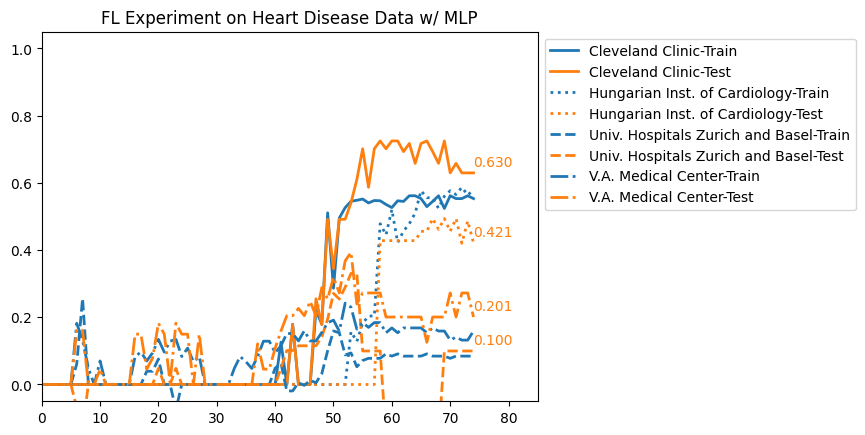

In [15]:
from matplotlib import pyplot as plt
from utils import plot_fl_metrics

plot_fl_metrics(datasites, fl_metrics, title="FL Experiment on Heart Disease Data w/ MLP")
plt.show()

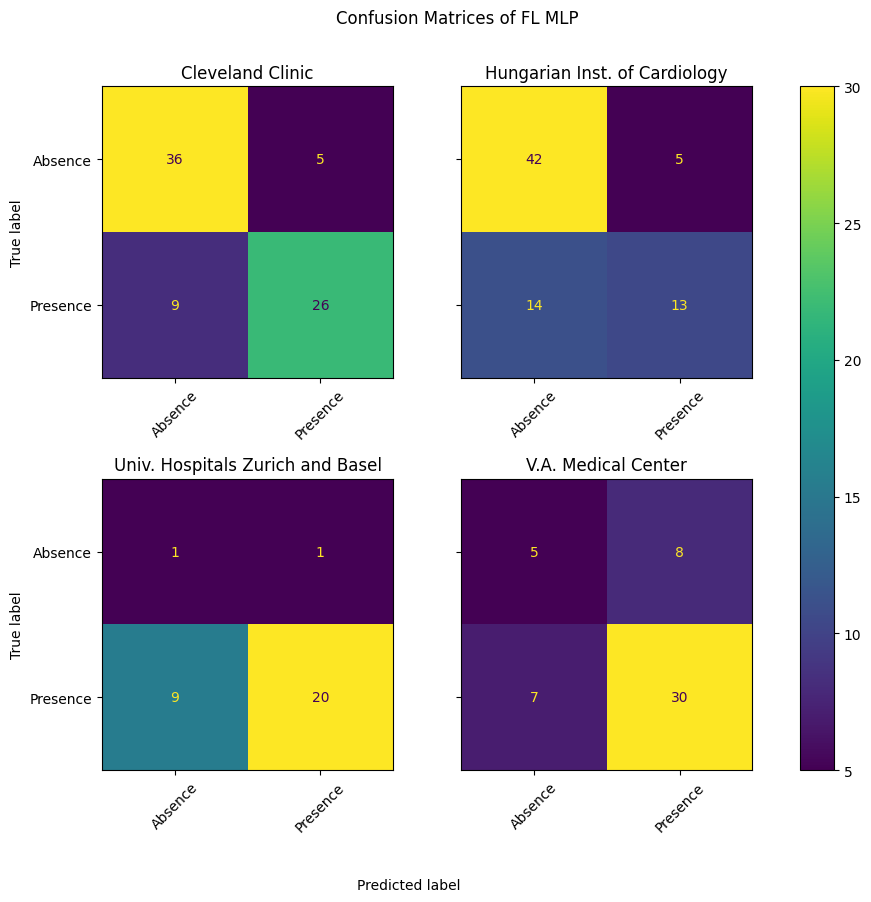

In [16]:
from utils import plot_all_confusion_matrices

last_epoch = sorted(fl_metrics)[-1]
confusion_matrices = {name: fl_metrics[last_epoch][idx][0][1]["cm"] for idx, name in enumerate(datasites)}
plot_all_confusion_matrices(confusion_matrices, title="Confusion Matrices of FL MLP")
plt.show()

## Conclusions

to complete